In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Inspect the data in measurement table
inspector = inspect(engine)
columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
# Inspect the data in station table
inspector = inspect(engine)
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [54]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date)\
                    .order_by(desc(Measurement.date))\
                    .first().date
most_recent_date

'2017-08-23'

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#Most recent date = most_recent_date or 2017-08-23

# Calculate the date one year from the last date in data set.
prev_year = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')-dt.timedelta(days=365)
prev_year

datetime.datetime(2016, 8, 23, 0, 0)

In [67]:
# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp)\
                .filter(Measurement.date >prev_year)\
                .order_by(Measurement.date).all()

In [68]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
precip_df = pd.DataFrame(result, columns=["Date", "Precipitation"]).sort_values("Date", ascending=True)
precip_df.set_index(precip_df["Date"], inplace=True)


precip_df


,Date,Precipitation
Date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,NaN
2016-08-24,2016-08-24,1.22
...,...,...
2017-08-22,2017-08-22,0.50
2017-08-23,2017-08-23,0.08
2017-08-23,2017-08-23,0.00


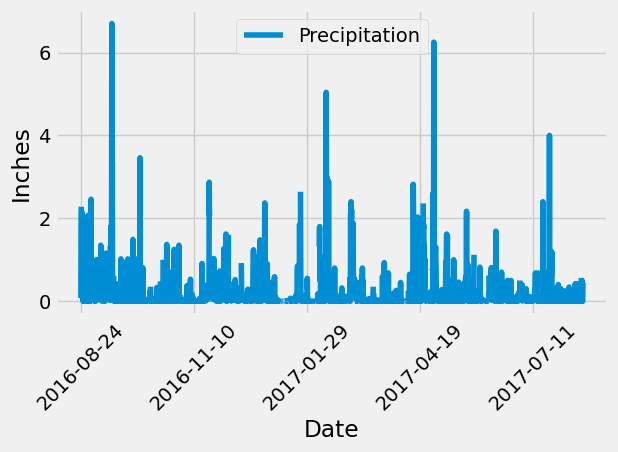

In [69]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=45)
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [70]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [73]:
# Inspect the data in measurement table
inspector = inspect(engine)
columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [72]:
# Inspect the data in station table
inspector = inspect(engine)
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [71]:
# Design a query to calculate the total number of stations in the dataset
total_num_stations = session.query(Station.station).count()
total_num_stations

9

In [74]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                        .order_by(func.count(Measurement.station).desc())\
                        .group_by(Measurement.station).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station))\
                        .order_by(func.count(Measurement.station).desc())\
                        .group_by(Measurement.station).first()
most_active_station

('USC00519281', 2772)

In [76]:
most_active_station_num = most_active_station[0]
most_active_station_num

'USC00519281'

In [78]:
#calculate the lowest temperature
lowest_temp = session.query(func.min(Measurement.tobs))\
                    .filter(Measurement.station==most_active_station_num).all()
lowest_temp

[(54.0,)]

In [79]:
#calculate the highest temperature
highest_temp = session.query(func.max(Measurement.tobs))\
                    .filter(Measurement.station==most_active_station_num).all()
highest_temp

[(85.0,)]

In [80]:
#calculate the average temperature
avg_temp = session.query(func.avg(Measurement.tobs))\
                    .filter(Measurement.station==most_active_station_num).all()
avg_temp

[(71.66378066378067,)]

In [85]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find most recent date for station USC00519281 in measurement table
most_recent_specific = session.query(Measurement.date, Measurement.tobs)\
                        .filter(Measurement.station == most_active_station_num)\
                        .order_by(Measurement.date.desc()).first()
most_recent_specific

('2017-08-18', 79.0)

In [90]:
prev_year_specific = dt.datetime.strptime(most_recent_specific[0], '%Y-%m-%d')-dt.timedelta(days=365) 
prev_year_specific

datetime.datetime(2016, 8, 18, 0, 0)

In [91]:
#Find dates 12 months before "most_recent_specific" for the most active station
values = session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.station == most_active_station_num)\
                .filter(Measurement.date >= prev_year_specific)\
                .all()
values

[('2016-08-19', 79.0),
 ('2016-08-20', 81.0),
 ('2016-08-21', 79.0),
 ('2016-08-22', 78.0),
 ('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-

In [92]:
# Create a dataframe with just "tobs"
twelve_mon_df = pd.DataFrame(values)["tobs"]
twelve_mon_df

0      79.0
1      81.0
2      79.0
3      78.0
4      77.0
       ... 
351    77.0
352    77.0
353    76.0
354    76.0
355    79.0
Name: tobs, Length: 356, dtype: float64

Text(0, 0.5, 'Frequency')

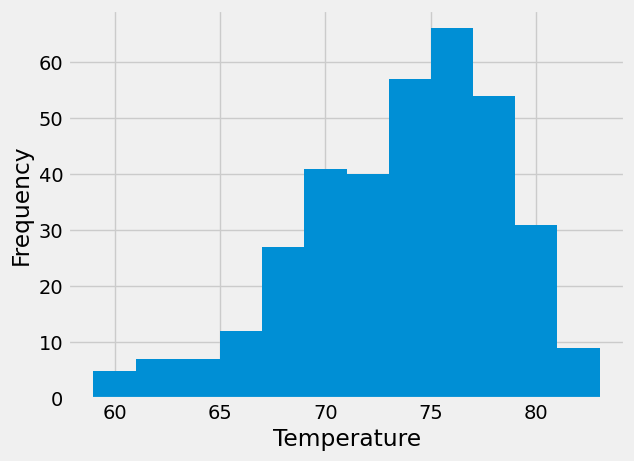

In [94]:
# Plot the data
twelve_mon_df.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Close Session

In [16]:
# Close Session
session.close()